In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import cv2 as cv
import os
import random
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [3]:
def model_skeleton(input_shape, num_classes):
    
    X_input = Input(input_shape)
    
    X = Conv2D(64, (5, 5), activation='relu', padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Conv2D(64, (5, 5), activation='relu', padding='same')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Dropout(0.4)(X)
    
    X = Conv2D(128, (5, 5), activation='relu', padding='same')(X)
    X = BatchNormalization()(X)
    X = Conv2D(128, (5, 5), activation='relu', padding='same')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Dropout(0.4)(X)
    
    X = Conv2D(256, (5, 5), activation='relu', padding='same')(X)
    X = BatchNormalization()(X)
    X = Conv2D(256, (5, 5), activation='relu', padding='same')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Dropout(0.5)(X)
    
    X = Flatten()(X)
    X = Dense(128, activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Dropout(0.6)(X)
    
    X = Flatten()(X)
    X = Dense(num_classes, activation='softmax')(X)
    
    
    model = Model(inputs = X_input, outputs = X, name='CNN_model')
    
    return model

In [4]:
def read_data():  
    data_set = pd.read_csv('data/model/input/train.csv').values
    examples = pd.read_csv('data/model/input/test.csv').values
    
    X = np.zeros((len(data_set), 48, 48, 1))
    Y = np.zeros((len(data_set), 1))
    
    for i in range(len(data_set)):
        image = data_set[i][1].split()
        tag = data_set[i][0]
 
        img = np.asarray(image, dtype=np.uint8).reshape(48,48,1)
        X[i] = img
        Y[i] = tag

    return [X, Y]

In [5]:
def one_hot_encoder(data) :
    output = np.array([[0, 1, 2, 3, 4, 5, 6]])
    onehot_encoder = OneHotEncoder(sparse=False, categories=output)
    integer_encoded = data.reshape(len(data), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

In [6]:
def draw_cost_figure(history, title):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model cost ' + title)
    plt.ylabel('cost')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')

In [7]:
def draw_accuracy_figure(history, title):
    plt.figure()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy ' + title)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')

In [8]:
def prepare_data():
    X, Y = read_data()
    X_train, X_valid, y_train, y_valid = train_test_split(X, Y, shuffle=False, test_size = 0.1)

    y_train = one_hot_encoder(y_train)
    y_valid = one_hot_encoder(y_valid)

    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
    )
    
    return X_train, X_valid, y_train, y_valid, train_datagen

In [9]:
def train_model_emotions(X_train, X_valid, y_train, y_valid, train_datagen):
    model = model_skeleton(X_train.shape[1:], 7)

    opt = Adam(lr=0.001)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
    model.summary()

    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=32),
        epochs = 100,
        verbose = True,
        validation_data = (X_valid, y_valid),
    )

    return model, history

In [10]:
def save_emotion_model(model):
    model_json = model.to_json()
    with open("data/model/output/modelemotion.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("data/model/output/modelemotion.h5")
    print("Saved model to disk")



In [11]:
def load_emotion_model():
    json_file = open('data/model/output/modelemotion.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()

    model = model_from_json(loaded_model_json)
    model.load_weights("data/model/output/modelemotion.h5")
    return model



In [12]:
def split_data(file_name, train_percentage):
    n_file = len(file_name)
    random.shuffle(file_name)
    n_train = math.floor(train_percentage * n_file)
    return file_name[:n_train], file_name[n_train:]
    

In [13]:
def format_image(line):
    image = line[3].split()
    mark = line[4]
    if mark < 4:
        tag = 0
    elif mark < 7:
        tag = 1
    else:
        tag = 2

    img = np.asarray(image, dtype=np.uint8).reshape(48,48,1)
    return img, tag

In [14]:
def read_csv_data(path, file_names):
    size = 0
    for i in range(len(file_names)):
        size += len(pd.read_csv(os.path.join(path, file_names[i])).values)
    
    X = np.zeros((size, 48, 48, 1))
    Y = np.zeros((size, 1))

    pointer = 0
    for i in range(len(file_names)):
        csv_file = pd.read_csv(os.path.join(path, file_names[i])).values
        for line in csv_file:

            img, tag = format_image(line)

            X[pointer] = img
            Y[pointer] = tag
            pointer += 1
                       
    return X, Y

In [15]:
def load_boredom_csv():
    #THE CSV FILES SHOULD BE MOVED MANUALLY FROM data/facecut/output_csv/ TO data/model/input/faces_csv/
    path = 'data/model/input/faces_csv/'
    content = os.listdir(path)
    data_set_cara = dict()

    train_name, test_name = split_data(content, 0.7)

    X_train , Y_train = read_csv_data(path, train_name)
    X_test , Y_test = read_csv_data(path, test_name)
    
    return  X_train, Y_train, X_test, Y_test


In [16]:
def transfer_learning_model(model):
    n_layers_to_remove = 10

    model_TL = Sequential()
    for layer in model.layers[:-n_layers_to_remove]: 
        layer.trainable = False
        model_TL.add(layer)

    model_TL.add(Conv2D(256, (5, 5), activation='relu', padding='same', name="relu_tl_1"))
    model_TL.add(BatchNormalization(name="batch_tl_1"))
    model_TL.add(MaxPooling2D((2, 2), name="max_pool_tl_1"))
    model_TL.add(Dropout(0.4, name="drop_out_tl_1"))
    model_TL.add(Flatten(name="flatten_tl_1"))

    model_TL.add(Dense(128, activation="relu", name="relu_tl_2"))
    model_TL.add(BatchNormalization(name="batch_tl_2"))
    model_TL.add(Dropout(0.4, name="drop_out_tl_2"))
    model_TL.add(Flatten(name="flatten_tl_2"))
    model_TL.add(Dense(3, activation="softmax", name="dense_tl_2"))
    
    return model_TL




In [17]:
def one_hot_encoder_bored(data) :
    output = np.array([[0, 1, 2]])
    onehot_encoder = OneHotEncoder(sparse=False, categories=output)
    integer_encoded = data.reshape(len(data), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

In [18]:
def train_model_boredom(model_TL, X_train, X_test, Y_train_encoded, Y_test_encoded):
    model_TL.compile(optimizer= Adam(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])

    history_TL = model_TL.fit(
        x = X_train,
        y = Y_train_encoded,
        batch_size = 24,
        epochs = 100,
        verbose = True,
        validation_data = (X_test, Y_test_encoded)
    )
    
    return model_TL, history_TL

In [19]:
def save_boredom_model(model_TL):
    model_json = model_TL.to_json()
    with open("data/model/output/modelboredom.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model_TL.save_weights("data/model/output/modelboredom.h5")
    print("Saved model to disk")
    


Emotions training:


C:\Users\concd\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories != 'auto':
C:\Users\concd\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:89: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories == 'auto':
C:\Users\concd\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories != 'auto':
C:\Users\concd\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:89: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories == 

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0 

C:\Users\concd\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories != 'auto':
C:\Users\concd\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:89: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories == 'auto':
C:\Users\concd\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories != 'auto':
C:\Users\concd\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:89: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories == 

1892/1892 [==============================] - 27s 13ms/step - loss: 0.7356 - acc: 0.7026 - val_loss: 1.4226 - val_acc: 0.3401
Saved model to disk


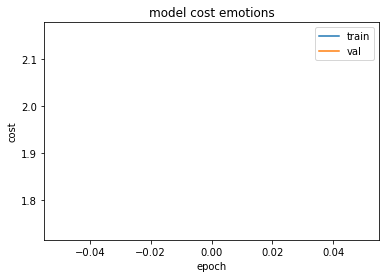

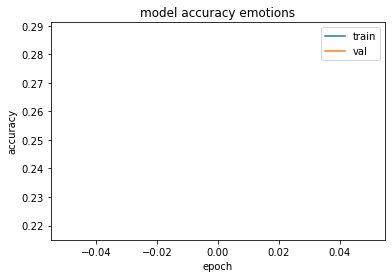

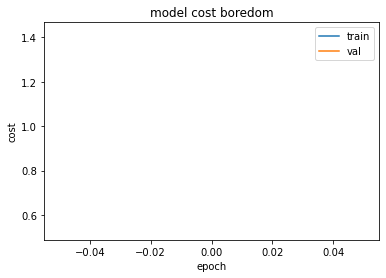

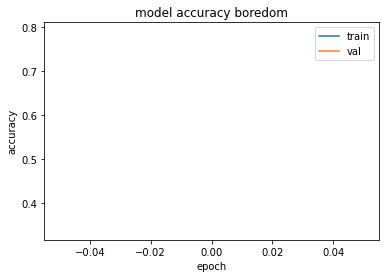

In [20]:
def main():
    #EMOTIONS
    print("\nEmotions training:")
    X_train, X_valid, y_train, y_valid, train_datagen = prepare_data()
    model, history = train_model_emotions(X_train, X_valid, y_train, y_valid, train_datagen)

    draw_cost_figure(history, "emotions")
    draw_accuracy_figure(history, "emotions")
    
    save_emotion_model(model)
    
    #BOREDOM
    print("\nBoredom training:")
    model = load_emotion_model()

    X_train, Y_train, X_valid, Y_valid = load_boredom_csv()
    Y_train_encoded = one_hot_encoder_bored(Y_train)

    Y_valid_encoded = one_hot_encoder_bored(Y_valid)
    model_TL = transfer_learning_model(model)


    model_TL, history_TL = train_model_boredom(model_TL, X_train, X_valid, Y_train_encoded, Y_valid_encoded)

    draw_cost_figure(history_TL, "boredom")
    draw_accuracy_figure(history_TL, "boredom")
    
    save_boredom_model(model)
    
main()